### LIBRERIAS

In [ ]:
import os, io
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
import math

### CARAGA DE LOS DATOS Y PREPROCESADO

Aplicamos a los datos el preprocesado de los datos explicado en el EDA

In [3]:
base_dir= "DATA"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

classes = ['melanoma', 'seborrheic_keratosis', 'nevus']

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)


val_test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
classes = ['melanoma', 'nevus', 'seborrheic_keratosis']

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=classes,           
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode='categorical',
    shuffle=False
)


Found 1002 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 599 images belonging to 3 classes.


### MODELO

La arquitectura de la CNN entrenada optimiza la extracción de características y la generalización en un dataset pequeño (1000 imágenes) sin recurrir a un modelo preentrenado. Tras la entrada 224×224×3, cuatro bloques de convolución con padding “same” emplean Conv2D→BatchNormalization→ReLU→MaxPooling para estabilizar y acelerar el aprendizaje, reduciendo progresivamente la resolución espacial. En lugar de “aplanar” el último mapa, GlobalAveragePooling2D condensa cada canal en un valor, disminuyendo drásticamente los parámetros y forzando un resumen global de las texturas de melanoma. Le sigue una capa densa de 256 neuronas (ReLU) con Dropout(0.5) para prevenir co-adaptaciones y, finalmente, una capa softmax de 3 salidas para clasificar las clases. Junto con data augmentation agresivo y callbacks de early stopping y checkpoint, este esquema ofrece un buen balance entre capacidad de representación y control de sobreajuste.

In [6]:
# Callbacks para controlar el entrenamiento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("skin_cnn.keras",
                    save_best_only=True,
                    monitor="val_loss",
                    verbose=1)
]

# Definición de la CNN
model = models.Sequential([
    layers.InputLayer(shape=(*IMG_SIZE, 3)),

    layers.Conv2D(32, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same"),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(3, activation="softmax")
])

# Compilación
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen de la arquitectura
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,035 (1.05 MB)

 Trainable params: 275,331 (1.05 MB)

 Non-trainable params: 704 (2.75 KB)

In [7]:
# Entrenamiento
history = model.fit(
    train_generator,
    epochs = 30,
    validation_data = val_generator,
    callbacks = callbacks
)


Epoch 1/30


c:\Users\maria\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3981 - loss: 1.1425
Epoch 1: val_loss improved from inf to 1.07798, saving model to skin_cnn.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.3993 - loss: 1.1408 - val_accuracy: 0.5200 - val_loss: 1.0780
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5015 - loss: 0.9721
Epoch 2: val_loss improved from 1.07798 to 1.06038, saving model to skin_cnn.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.5021 - loss: 0.9717 - val_accuracy: 0.5200 - val_loss: 1.0604
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5519 - loss: 0.9029
Epoch 3: val_loss improved from 1.06038 to 1.05276, saving model to skin_cnn.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.5515 - loss: 0.9036 - val_accuracy: 0.5200 - val_loss: 1.0528
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5566 - loss: 0.9030
Epoch 4: val_loss did not improve from 1.05276
32/32 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step

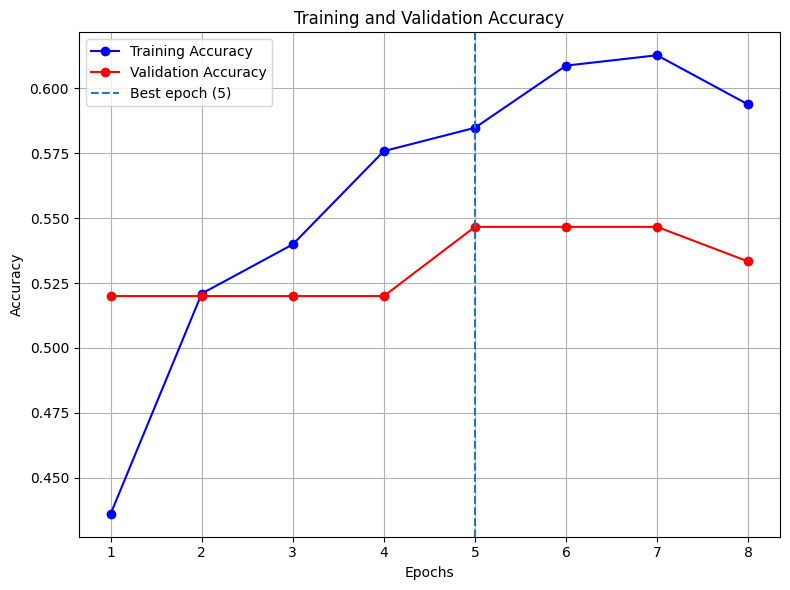

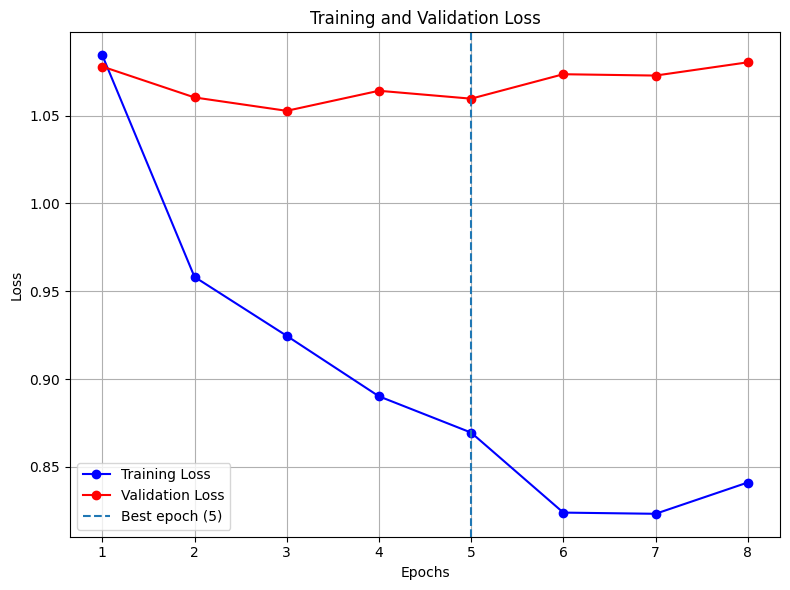

Mejor epoch: 5 — val_acc: 0.547, val_loss: 1.060


In [13]:
#  Extrae las curvas
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Encuentra la mejor época (por val_acc)
best_epoch    = np.argmax(val_acc) + 1
best_val_acc  = val_acc[best_epoch-1]
best_val_loss = val_loss[best_epoch-1]

# Plot de accuracy
plt.figure(figsize=(8,6))
plt.plot(epochs, acc,    'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc,'ro-', label='Validation Accuracy')
plt.axvline(best_epoch, linestyle='--', label=f'Best epoch ({best_epoch})')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5) Plot de loss
plt.figure(figsize=(8,6))
plt.plot(epochs, loss,     'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.axvline(best_epoch, linestyle='--', label=f'Best epoch ({best_epoch})')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6) Opcional: imprime los valores del mejor epoch
print(f"Mejor epoch: {best_epoch} — val_acc: {best_val_acc:.3f}, val_loss: {best_val_loss:.3f}")


In [ ]:
steps = math.ceil(test_generator.samples / BATCH_SIZE)
test_loss, test_acc = model.evaluate(test_generator, steps=steps, verbose=1)
print(f"Precisión en test: {test_acc:.3f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 119s 6s/step - accuracy: 0.5051 - loss: 1.0082
Precisión en test: 0.656


La CNN entrenada desde cero presentó los siguientes resultados de precisión (accuracy):

- Train accuracy: aumentó de ≈ 0,43 en las primeras épocas hasta ≈ 0,60 al final.

- Validation accuracy: alcanzó un máximo de 0,547 en la época 5 (val_loss ≈ 1,060) y a partir de ahí se ha estancando.

- Test accuracy: se situó en 0,5051, muy próximo al 0,33 de una clasificación aleatoria en tres clases.

Las curvas de training/validation accuracy y loss muestran claramente ese comportamiento: tras la época óptima, la brecha entre entrenamiento y validación se amplía, señal clara de un leve sobreajuste. El hecho de que el test accuracy quede en torno al 50 % confirma la limitada capacidad de generalización del modelo entrenado desde cero y esto es debido en parte al tamaño del conjunto de entrenamiento siendo solo de 1000 imágenes.

Emplear transfer learning con un modelo preentrenado (p. ej. ResNet50 o EfficientNet) debería mejorar estos resultados: al aprovechar filtros ya aprendidos y reducir drásticamente el número de parámetros entrenables, se mitiga tanto el underfitting inicial como el sobreajuste, elevando la precisión global y la sensibilidad (recall) en la detección de melanoma.

### PUESTA EN PRODUCCION DEL MODELO

In [18]:
model = load_model('skin_cnn.keras')


def predict_image(img_path, model, classes):
    """
    Carga una imagen, la preprocesa y devuelve la predicción.
    """
    # a) Carga y redimensiona
    img = image.load_img(img_path, target_size=(224, 224))
    # b) A array y normaliza 
    x = image.img_to_array(img) / 255.0
    # c) Añade dimensión batch
    x = np.expand_dims(x, axis=0)
    # d) Inferencia
    preds = model.predict(x)
    # e) Obtiene índice y probabilidad
    idx = np.argmax(preds[0])
    return classes[idx], float(preds[0][idx])

if __name__ == '__main__':
    # RUTA_IMAGEN: sustituye por la ruta de tu imagen o pásala como argumento
    RUTA_IMAGEN = 'C:\\Users\\maria\\repo\\ADNE_imagen\\DATA\\train\\_discarded\\ISIC_0002976.jpg' # es una imagen de nevus de las descartadas de train
    
    etiqueta, probabilidad = predict_image(RUTA_IMAGEN, model, classes)
    print(f'Imagen: {RUTA_IMAGEN}')
    print(f'Predicción: {etiqueta}  (probabilidad: {probabilidad:.2f})')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
Imagen: C:\Users\maria\repo\ADNE_imagen\DATA\train\_discarded\ISIC_0002976.jpg
Predicción: nevus  (probabilidad: 0.41)


En esta ocasión el modelo ha acertado con la clase de enfermedad de la piel pero con un bajo porcentaje de probabilidad. Seguramente debido a los bajos resultados obtenidos en las metricas de accuracy 